# Hybrid CART

# Imports

In [5]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.data_processor import Data_processor
from utils.evaluator import evaluator

import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import prince
import numpy as np

import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix


Load hybrids cars

In [8]:
data = Loader.load_by_fueltype("Híbrido")
label_encoder = LabelEncoder()

d:\Archivos Uni\3 anio\Machine Learning\Proyect\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
d:\Archivos Uni\3 anio\Machine Learning\Proyect\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
d:\Archivos Uni\3 anio\Machine Learning\Proyect\Cars_Price_Prediction\Trees\..\utils\loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method

In [9]:
data["price_categ"].value_counts()

price_categ
Middle low range     6780
Middle range         3700
Middle high range    2364
Premiun              2137
Luxury               1829
High end             1766
Budget               1367
Low end               147
Very low end            9
Name: count, dtype: int64

In [10]:
data['price_categ'] = data['price_categ'].replace({ # Combinar clases similares
    'Luxury': 'Alto',
    'Premiun': 'Alto',
    'High end': 'Alto',
    'Middle high range': 'Alto',
})

data = data[data['price_categ'] != 'Very low end'] # Eliminar la clase 'Very low end'
data['price_categ'] = data['price_categ'].str.strip()

# Revisa la nueva distribución
data['price_categ'].value_counts()

C:\Users\gipas\AppData\Local\Temp\ipykernel_5040\787252135.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  data['price_categ'] = data['price_categ'].replace({ # Combinar clases similares


price_categ
Alto                8096
Middle low range    6780
Middle range        3700
Budget              1367
Low end              147
Name: count, dtype: int64

In [11]:
# Ajustar y transformar la columna price_categ
data['price_categ'] = label_encoder.fit_transform(data['price_categ'])
data['price_categ'].value_counts()

price_categ
0    8096
3    6780
4    3700
1    1367
2     147
Name: count, dtype: int64

This result is telling us that in the wolrd of hybrid cars is much common to have a high price car than a low end hybrid car. So as we can see that our dataset is not perfectly balanced so we are going to studie and transfor this data to make it more tratable for the cart tree 

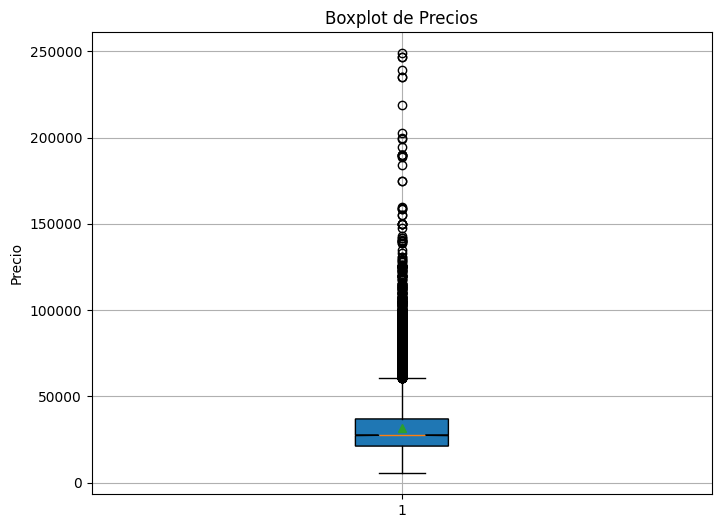

In [13]:
precios_hibridos = data["price"]
plt.figure(figsize=(8, 6))
plt.boxplot(precios_hibridos, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

The outliers were checked manually throught the data source, and we could confirmed that they are not outliers

In [14]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)  # Esta es la mediana
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)

60600.0


,price,brand
idx,,
1412,248900,LAND-ROVER
130244,246743,LAND-ROVER
129813,246743,LAND-ROVER
12846,239000,LAND-ROVER
53326,234900,LAND-ROVER
...,...,...
123654,60900,VOLVO
37177,60900,VOLVO
135706,60800,MERCEDES-BENZ


PCA and correlation matrix

In [15]:
def fill_hybrid_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    #fill the elemental columns that has a minor amount of missing data with the mode
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.length")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.height")

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")

    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

def get_hybrid_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])
    numerical_columns.drop(columns=[ "car_id"], inplace=True)

    #if all the values of the numerical columns is 0, we remove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)

    #Remove the column with all NAs
    max_nans = 6586
    thresh = numerical_columns.shape[0] - max_nans

    numerical_columns.dropna(axis=1, thresh=thresh+1, inplace=True)
    return fill_hybrid_numerical_columns(numerical_columns)

In [16]:
numerical_columns = get_hybrid_numerical_columns(data)

Regression mape ['dimensions.length', 'dimensions.height'] -> dimensions.width: 1.1914943513541185%
Regression mape ['dimensions.length', 'dimensions.height', 'dimensions.width'] -> trunkCapacityInLiters: 13.023169389717273%
Regression mape ['power_cv', 'power_kw'] -> maxSpeed: 7.810033917269718%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 7.152370408002295%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 6.843704148981194%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> max_torque_nm: 20.641240227524193%


In [17]:
correlation_matrix = numerical_columns.corr()["price"]
print(correlation_matrix)

price                    1.000000
km                      -0.158428
year                     0.313300
cubicCapacity            0.577062
doors                    0.041924
seatingCapacity          0.234733
trunkCapacityInLiters    0.431445
maxSpeed                 0.580134
acceleration            -0.605894
power_cv                 0.756218
power_kw                 0.756342
max_torque_nm            0.762912
speakers                 0.369830
dimensions.width         0.645665
dimensions.height        0.344087
dimensions.length        0.606929
Numero_Testigos          0.096637
displacement_liters      0.575860
displacement_cc         -0.318150
number_of_cylinders      0.562844
compression_ratio       -0.249124
Llantas_Diametro_cm      0.626694
price_categ             -0.537680
Name: price, dtype: float64


In [18]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

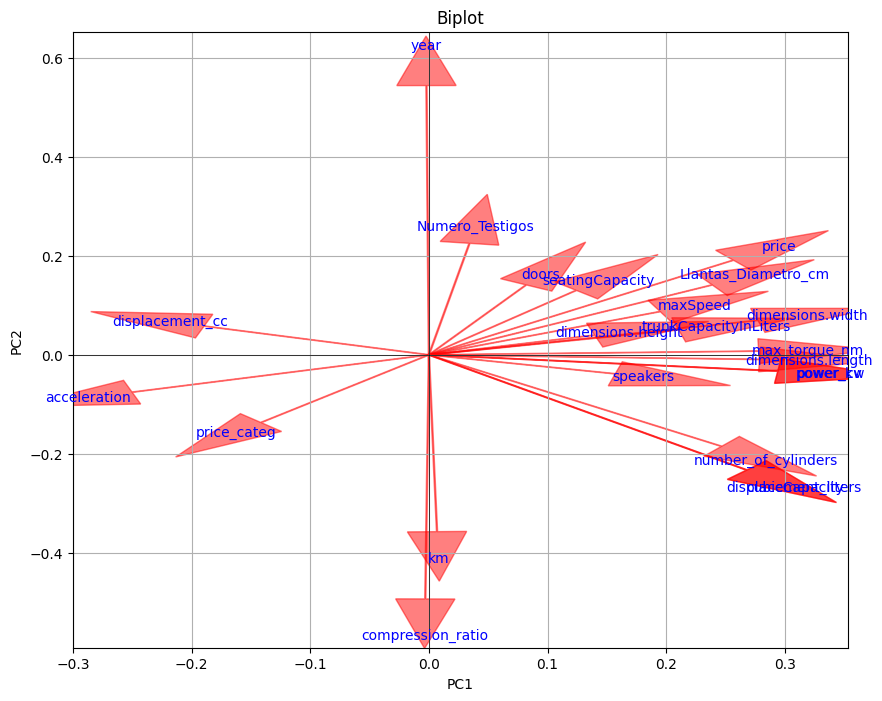

In [19]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

## CART Tree with only numerical coulumns

### First try

In [20]:
X = numerical_columns.drop(columns=["price_categ","price"]) # + price_categ
y = numerical_columns["price_categ"]

In [21]:
# Train-Test Split Before Applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [23]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

In [24]:
y_pred = clf.predict(X_test)

# Cell 7: Evaluate the Model
# Print classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      1625
           1       0.83      0.89      0.86       260
           2       0.63      0.71      0.67        24
           3       0.91      0.90      0.91      1353
           4       0.76      0.78      0.77       756

    accuracy                           0.89      4018
   macro avg       0.82      0.84      0.83      4018
weighted avg       0.89      0.89      0.89      4018

Confusion Matrix:
 [[1529    4    0    5   87]
 [   0  232   10   16    2]
 [   0    6   17    1    0]
 [   4   36    0 1217   96]
 [  72    0    0   96  588]]
